In [1]:
!nvidia-smi

Fri Apr 12 13:33:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060       WDDM | 00000000:01:00.0  On |                  N/A |
|  0%   36C    P8               18W / 180W|   1196MiB / 12288MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
torch.cuda.is_available()

True

In [5]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [94]:
def get_bounding_box(ground_truth_map):
    # get bounding box from mask
    y_indices, x_indices = np.where(ground_truth_map > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates
    H, W = ground_truth_map.shape
    x_min = max(0, x_min - np.random.randint(0, 20))
    x_max = min(W, x_max + np.random.randint(0, 20))
    y_min = max(0, y_min - np.random.randint(0, 20))
    y_max = min(H, y_max + np.random.randint(0, 20))
    bbox = [x_min, y_min, x_max, y_max]

    return bbox

In [95]:
from torch.utils.data import Dataset
import numpy as np

class SAMDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item["image"]
        ground_truth_mask = np.array(item["mask"])

        # get bounding box prompt based on ground_truth_mask, assuming function get_bounding_box is defined elsewhere
        prompt = get_bounding_box(ground_truth_mask)

        # prepare image and prompt for the model
        inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

        # remove batch dimension which the processor adds by default
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        # convert mask to label indices using label_dict if necessary
        # Example: Convert mask if stored as categorical labels in the 'mask' attribute
        label_mask = np.vectorize(self.label_dict.get)(ground_truth_mask)

        # add ground truth segmentation as labels
        inputs["ground_truth_mask"] = label_mask

        return inputs

In [96]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [97]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [98]:
from PIL import Image
from datasets import Dataset
import os

def create_image_dataset(image_folder_path, mask_folder_path, target_size=(256, 256)):
    image_paths = []
    mask_paths = []
    
    for image_file in os.listdir(image_folder_path):
        if image_file.endswith(".jpg") or image_file.endswith(".jpeg") or image_file.endswith(".png"):
            image_path = os.path.join(image_folder_path, image_file)
            mask_file = f"masked_image_{image_file}"
            mask_path = os.path.join(mask_folder_path, mask_file)
            
            if os.path.isfile(mask_path):
                # 이미지와 마스크를 열고 리사이징
                image = Image.open(image_path).resize(target_size)
                mask = Image.open(mask_path).resize(target_size)
                
                # 그레이스케일 이미지를 RGB로 변환
                if image.mode == 'L':
                    image = image.convert('RGB')
                
                image_paths.append(image)
                mask_paths.append(mask)
    
    dataset = Dataset.from_dict({
        'image': image_paths,
        'mask': mask_paths
    })
    
    return dataset

image_folder_path = './data/eye_image_seg_xl/images_data'
mask_folder_path = './data/eye_image_seg_xl/labeled_data/masked_images'

dataset = create_image_dataset(image_folder_path, mask_folder_path, target_size=(256, 256))

print(dataset[0]['image'].size, dataset[0]['mask'].size)

(256, 256) (256, 256)


이미지 채널 수: RGB
이미지 채널 수: RGB


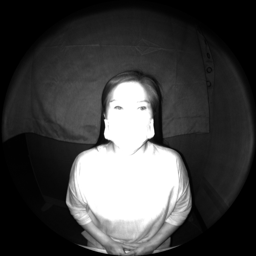

In [99]:
example = dataset[512]
image = example["image"]
image.size
channels = image.mode
print("이미지 채널 수:", channels)
image = image.convert('RGB')
channels = image.mode
print("이미지 채널 수:", channels)
image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

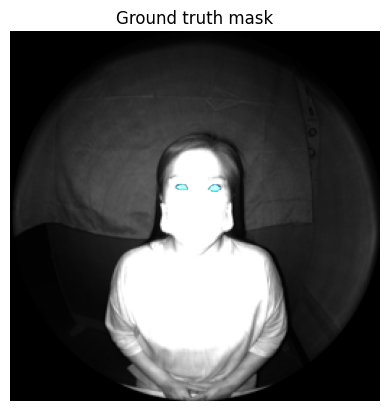

In [100]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["mask"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

In [101]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [102]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [103]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

AttributeError: 'SAMDataset' object has no attribute 'label_dict'

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape)

In [ ]:
batch["ground_truth_mask"].shape

In [104]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base", num_labels=7)

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

In [65]:
pip install -q monai

Note: you may need to restart the kernel to use updated packages.


In [105]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [106]:
from tqdm import tqdm
import torch

num_epochs = 3

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    epoch_iterator = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for batch in epoch_iterator:
        # Forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

        # Backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # Optimize
        optimizer.step()

        epoch_losses.append(loss.item())
        epoch_iterator.set_postfix({"loss": loss.item()})

    # Print epoch loss
    mean_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"EPOCH: {epoch+1} | Mean loss: {mean_loss}")


Epoch 1/3:   0%|                                                                           | 0/1104 [00:00<?, ?batch/s]


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found object

In [70]:
torch.save(model.state_dict(), "eyeball_model.pth")

In [20]:
from PIL import Image
from datasets import Dataset
import os

def create_image_dataset(image_folder_path, mask_folder_path, target_size=(256, 256)):
    image_paths = []
    mask_paths = []
    
    for image_file in os.listdir(image_folder_path):
        if image_file.endswith(".jpg") or image_file.endswith(".jpeg") or image_file.endswith(".png"):
            image_path = os.path.join(image_folder_path, image_file)
            mask_file = f"masked_image_{image_file}"
            mask_path = os.path.join(mask_folder_path, mask_file)
            
            if os.path.isfile(mask_path):
                # 이미지와 마스크를 열고 리사이징
                image = Image.open(image_path).resize(target_size)
                mask = Image.open(mask_path).resize(target_size)
                
                # 그레이스케일 이미지를 RGB로 변환
                if image.mode == 'L':
                    image = image.convert('RGB')
                
                image_paths.append(image)
                mask_paths.append(mask)
    
    dataset = Dataset.from_dict({
        'image': image_paths,
        'mask': mask_paths
    })
    
    return dataset

image_folder_path = './data/eye_image_seg_xl/images_data'
mask_folder_path = './data/eye_image_seg_xl/labeled_data/masked_images'

dataset = create_image_dataset(image_folder_path, mask_folder_path, target_size=(256, 256))

print(dataset[0]['image'].size, dataset[0]['mask'].size)

(256, 256) (256, 256)


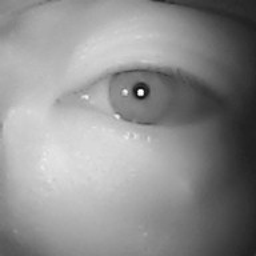

In [39]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 2000

# load image
image = dataset[idx]["image"]
image

In [43]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["mask"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
    print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [44]:
from transformers import SamModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the SAM model
model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)

# Disable gradient computation for specific parts of the model
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad_(False)

# Load your custom state dictionary
state_dict = torch.load("eyeball_model.pth", map_location=device)

# Try to load the state dictionary with error handling
try:
    # The strict=False argument allows the model to load parameters that do fit, and ignore others.
    model.load_state_dict(state_dict, strict=False)
    print("Some parameters were loaded successfully.")
except RuntimeError as e:
    print(f"Error loading state dictionary: {e}")

# Optional: Check which parameters were not loaded
missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)
print("Missing keys:", missing_keys)
print("Unexpected keys:", unexpected_keys)

Some parameters were loaded successfully.
Missing keys: []
Unexpected keys: []


In [84]:
model.eval()

# forward pass
with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

In [85]:
print(outputs)

SamImageSegmentationOutput(iou_scores=tensor([[[1.1400]]], device='cuda:0'), pred_masks=tensor([[[[[-317011.4062, -281174.3750, -291386.1875,  ...,
            -325217.9062, -247804.7031, -258540.0000],
           [-437199.4688, -541002.8750, -551869.3750,  ...,
            -442439.3125, -288917.6562, -276500.3125],
           [-371267.7500, -296686.6250, -456810.1250,  ...,
            -314641.9688, -389538.1562, -324029.0625],
           ...,
           [-469456.3125, -652568.6250, -721201.3125,  ...,
            -736235.8125, -699672.3125, -700250.9375],
           [-202382.9688, -142739.5000, -243480.8750,  ...,
            -288426.8438, -396467.5938, -307673.6875],
           [-544531.6250, -634217.2500, -999465.1250,  ...,
            -634846.2500, -778061.7500, -762052.7500]]]]], device='cuda:0'), vision_hidden_states=None, vision_attentions=None, mask_decoder_attentions=None)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


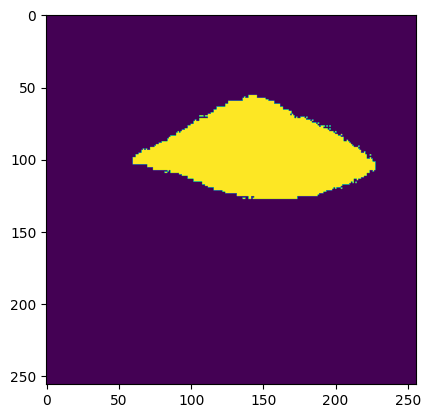

In [86]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
print(medsam_seg)
plt.imshow(medsam_seg)

In [93]:
# 순전파 진행
with torch.no_grad():
    # multimask_output을 True로 설정하여 각 라벨에 대한 마스크를 개별적으로 얻음
    outputs = model(**inputs, multimask_output=True)

# 출력 확인
print(outputs)

# 예측된 마스크에 시그모이드 함수 적용 (확률로 변환)
pred_masks = torch.sigmoid(outputs.pred_masks)

print(pred_masks)

2


In [63]:
medsam_seg_probs = torch.softmax(outputs.pred_masks, dim=1)

In [64]:
medsam_seg_probs

tensor([[[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]]], device='cuda:0')

In [69]:
# Convert soft masks to hard masks by thresholding
threshold = 0.5
# Use the tensor's own greater than method to create a mask and convert to uint8
medsam_seg = (medsam_seg_probs > threshold).to(torch.uint8)

# If you need to move this to CPU and convert to a numpy array for further processing:
medsam_seg_np = medsam_seg.cpu().numpy()

In [66]:
medsam_seg_np

array([[[[[1, 1, 1, ..., 1, 1, 1],
          [1, 1, 1, ..., 1, 1, 1],
          [1, 1, 1, ..., 1, 1, 1],
          ...,
          [1, 1, 1, ..., 1, 1, 1],
          [1, 1, 1, ..., 1, 1, 1],
          [1, 1, 1, ..., 1, 1, 1]]]]], dtype=uint8)

In [ ]:
plt.imshow(medsam_seg)

In [71]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)
print(medsam_seg)
plt.imshow(medsam_seg)

In [72]:
print(medsam_seg)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


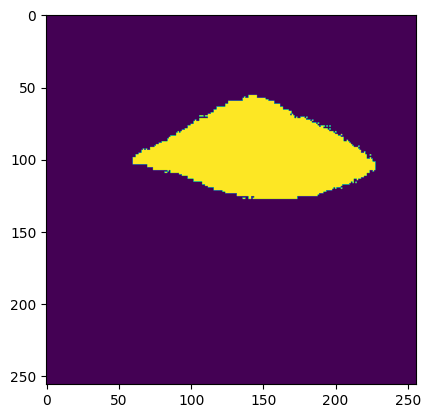

In [73]:
plt.imshow(medsam_seg)

(-0.5, 255.5, 255.5, -0.5)

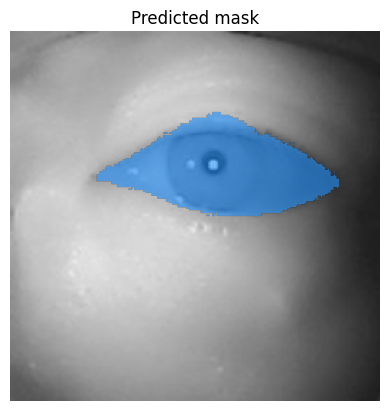

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

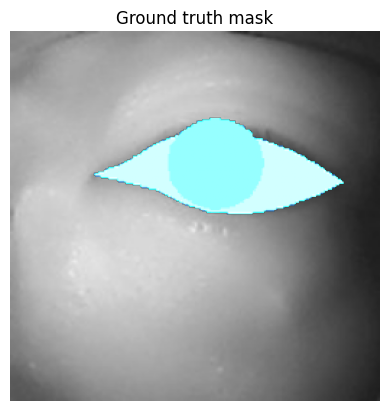

In [48]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")